In [1]:
!gpustat

blade                Tue Jul  6 14:29:57 2021  455.45.01
[0] RTX A6000        | 42'C,   0 % | 44886 / 48685 MB | wangh19(44883M)
[1] RTX A6000        | 35'C,   0 % |     0 / 48685 MB |
[2] RTX A6000        | 40'C,   0 % |     0 / 48685 MB |
[3] RTX A6000        | 35'C,   0 % |     0 / 48685 MB |
[4] RTX A6000        | 36'C,   0 % |     0 / 48685 MB |
[5] RTX A6000        | 33'C,   0 % |     0 / 48685 MB |
[6] RTX A6000        | 38'C,   0 % |     0 / 48685 MB |
[7] RTX A6000        | 35'C,   3 % |     0 / 48685 MB |


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import numpy as onp
from numpy import fft
import jax.numpy as np
from jax import random, grad, vmap, jit, lax
from jax.experimental import optimizers
from jax.experimental.optimizers import make_schedule
from jax.experimental.ode import odeint
from jax.nn import relu, leaky_relu, swish, sigmoid
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from jax import jacobian, eval_shape
from jax.tree_util import tree_map, tree_multimap, tree_reduce 
from jax.flatten_util import ravel_pytree
from jax.ops import index_update, index

from jaxpinns.optimizers import mdmm_adam

import neural_tangents as nt
import operator

from jax.scipy.stats.norm import logpdf, pdf


from tqdm import trange, tqdm

import time
%matplotlib inline
from IPython.display import clear_output

In [4]:
path = '2d_toy/'

In [5]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16,
                        'lines.linewidth': 2,
                        'axes.labelsize': 10,
                        'axes.titlesize': 16,
                        'xtick.labelsize': 10,
                        'ytick.labelsize': 10,
                        'legend.fontsize': 10,
                        'axes.linewidth': 2})

In [6]:
from helpers import *

In [7]:
class sampler:
    def __init__(self, X, Y, batch_size):

        self.X = X
        self.Y = Y
        self.batch_size = batch_size
    @partial(jit, static_argnums=(0,))
    def sample(self, key):
        idx = random.choice(key, np.arange(self.X.shape[0]), shape = (batch_size,), replace = False)
        return (self.X[idx], self.Y[idx])

In [8]:
key = random.PRNGKey(int(time.time()*100))

In [9]:
def target_fn_gen(max_freq, key = random.PRNGKey(0)):
    k1, k2 = random.split(key)
    As = random.uniform(k1, shape = (4,2)) * 2
    fs = random.uniform(k2, shape = (4, 4)) * max_freq
    
    def target_fn(X):
        cs = []
        for A, f in zip(As, fs):
            cs.append(A[0] * np.sin(np.pi * f[0] * X[:, 0]) * np.cos(np.pi * f[1] * X[:,1]) + A[1] * np.sin(np.pi * f[2] * X[:, 0]) * np.cos(np.pi * f[3] * X[:,1]))
        return np.array(cs).sum(0)
    return target_fn

In [10]:
max_freq = 48
target_fn = target_fn_gen(max_freq, key = key)

In [11]:
X = random.uniform(key, shape = (2**16, 2), minval = -1, maxval = 1)
Y = target_fn(X)
Y = Y + random.normal(random.split(key)[0], shape = Y.shape)*Y.std(0)*0.01
mu_X, sigma_X = X.mean(0), X.std(0)
X = (X - mu_X) / sigma_X
mu_Y, sigma_Y = Y.mean(0), Y.std(0)
Y = (Y - mu_Y) / sigma_Y

In [12]:
X_test = np.array(np.meshgrid(np.linspace(-1,1,200), np.linspace(-1,1,200))).transpose((1,2,0)).reshape(-1,2)
Y_test = target_fn(X_test)

X_test = (X_test - mu_X) / sigma_X
Y_test = (Y_test - mu_Y) / sigma_Y

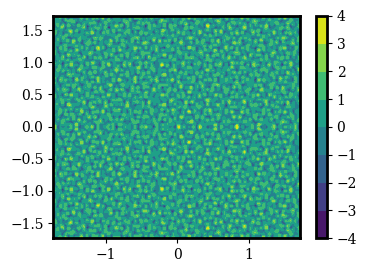

In [13]:
plt.figure(figsize = (4,3))
plt.contourf(X_test[:,0].reshape(200, 200), X_test[:,1].reshape(200, 200), Y_test.reshape(200, 200))
plt.colorbar()
plt.tight_layout()
plt.show()
plt.close()

In [14]:
layers = [X.shape[1], *[256 for _ in range(16)], 1]
activation = np.tanh
fit_model = MLPRegression(layers, activation = activation)

In [15]:
batch_size = 2048
data_sampler = sampler(X, Y, batch_size)

In [16]:
init_model = initNet(layers[:-1], activation = activation)
#init_model.plot_degree(init_model.scale_params, fit_model.net_params[:-1], X, word = False)

In [17]:
lr = 5e-3
init_fn, update_fn, get_params = optimizers.adam(lr)
# init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)
lam = 1e-4
@jit
def step(i, state, X):
    key = random.PRNGKey(i)
    g = grad(init_model.regulated_logSineLoss)(get_params(state), init_model.net_init(key), X, lam = lam)
    return update_fn(i, g, state)
print(f'Important: confirm lam {lam} before running!!!!!!!!!!!!!!!')

Important: confirm lam 0.0001 before running!!!!!!!!!!!!!!!


In [18]:
opt_state = init_fn(init_model.scale_params)
init_nIter = 20000
pbar = trange(init_nIter)
scale_stor = []
bias_stor = []

for i in pbar:
    mini_batch = data_sampler.sample(random.PRNGKey(i))[0]
    opt_state = step(i, opt_state, mini_batch)
    
    if i % 100 == 0:
        params = get_params(opt_state)
        pbar.set_postfix({'Log sine loss': init_model.logSineLoss(get_params(opt_state), init_model.net_init(random.PRNGKey(i)), mini_batch)})
        scale_stor.append([w for (w, b) in params])
        bias_stor.append([b for (w, b) in params])
        

scale_stor = np.array(scale_stor)
bias_stor = np.array(bias_stor)
        


100%|██████████| 20000/20000 [01:11<00:00, 279.24it/s, Log sine loss=0.009148732] 


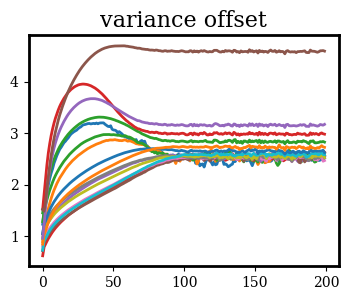

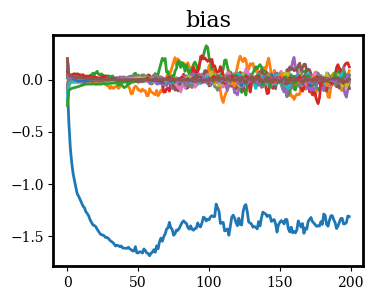

In [19]:
plt.figure(figsize = (4,3))
for i, s in enumerate(scale_stor.T):
    plt.plot(s, label = f'Layer {int(i)}')
# plt.legend()
plt.title('variance offset')
plt.show()
plt.close()

plt.figure(figsize = (4,3))
for i, s in enumerate(bias_stor.T):
    plt.plot(s, label = f'Layer {int(i)}')
# plt.legend()
plt.title('bias')
plt.show()
plt.close()

In [20]:
scale_params = params

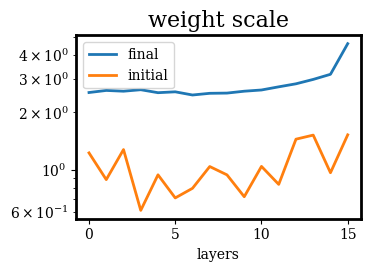

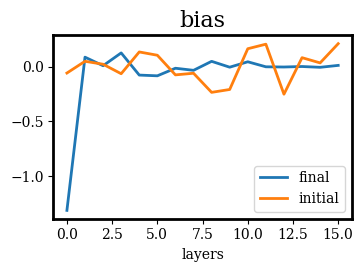

In [21]:
plt.figure(figsize = (4,3))

plt.plot([w_init for w_init, b_init in scale_params], label = 'final')
plt.plot([w_init for w_init, b_init in init_model.scale_params], label = 'initial')

plt.yscale('log')
plt.xlabel('layers')
plt.legend()
plt.title('weight scale')
plt.tight_layout()

plt.show()
plt.close()

plt.figure(figsize = (4,3))

plt.plot([b_init for w_init, b_init in scale_params], label = 'final')
plt.plot([b_init for w_init, b_init in init_model.scale_params], label = 'initial')

plt.xlabel('layers')
plt.legend()
plt.title('bias')
plt.tight_layout()

plt.show()
plt.close()

In [22]:
fit_model.scaled_net_params = parameter_scaling(fit_model.net_params[:-1], scale_params) + [fit_model.net_params[-1]]

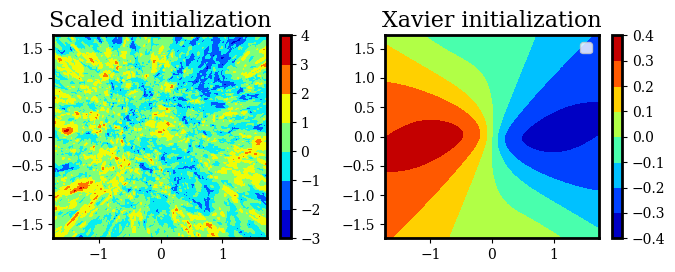

In [23]:
plt.figure(figsize = (7,3))
plt.subplot(1,2,1)
plt.tricontourf(X_test[:,0], X_test[:,1], fit_model.net_apply(fit_model.scaled_net_params, X_test).flatten(), cmap = 'jet')
plt.colorbar()
plt.title('Scaled initialization')
plt.tight_layout()
plt.subplot(1,2,2)
plt.tricontourf(X_test[:,0], X_test[:,1], fit_model.net_apply(fit_model.net_params, X_test).flatten(), cmap = 'jet')
plt.colorbar()
plt.title('Xavier initialization')
plt.tight_layout()

plt.show()
plt.close()

In [24]:
key = random.PRNGKey(int(time.time()*100))

In [25]:
# lr = 1e-3
# init_fn, update_fn, get_params = optimizers.nesterov(lr, 0.9)

init_fn, update_fn, get_params = optimizers.adam(optimizers.exponential_decay(5e-4, decay_steps = 400, decay_rate = 0.99))

@jit
def step(i, state, batch):
    g = grad(fit_model.loss)(get_params(state), batch)
    return update_fn(i, g, state)

In [26]:
nIter = 120000

In [27]:
pbar = trange(nIter)

# stack the parameter trees at each leaf node for vmap
init_paramses = tree_multimap(stack_fn, fit_model.net_params, fit_model.scaled_net_params)
opt_state = vmap(init_fn)(init_paramses)
# compile the vmap optimization step
v_step = jit(vmap(step, in_axes = (None, 0, None)))
loss_stor = []

for i in pbar:
    mini_batch = data_sampler.sample(random.PRNGKey(i))
    opt_state = v_step(i, opt_state, mini_batch)
    if i % 1000 == 0:
        params = vmap(get_params)(opt_state)
        loss_val = vmap(fit_model.loss, in_axes = [0, None])(params, mini_batch)
        
        loss_stor.append(loss_val)
        pbar.set_postfix({'loss': loss_val})
        


100%|██████████| 120000/120000 [05:31<00:00, 362.51it/s, loss=[9.8837852e-01 1.8076984e-04]]


In [28]:
loss_stor = np.array(loss_stor)

opt_params = vmap(get_params)(opt_state)
normal_opt_params = tree_map(lambda x: x[0], opt_params)
scaled_opt_params = tree_map(lambda x: x[1], opt_params)

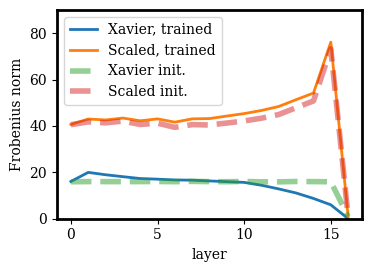

In [34]:
plt.figure(figsize = (4,3))
plt.plot(layer_weight_norm(normal_opt_params), label = 'Xavier, trained')
plt.plot(layer_weight_norm(scaled_opt_params), label = 'Scaled, trained')
plt.plot(layer_weight_norm(fit_model.net_params), linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Xavier init.')
plt.plot(layer_weight_norm(fit_model.scaled_net_params), linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Scaled init.')
plt.legend(loc = 'upper left')
plt.xlabel('layer')
plt.ylabel(r'Frobenius norm')
plt.ylim([0, 90])
plt.tight_layout()
plt.savefig(path + f'2d_toy_norm_{int(max_freq)}.pdf', dpi = 200)
plt.show()
plt.close()

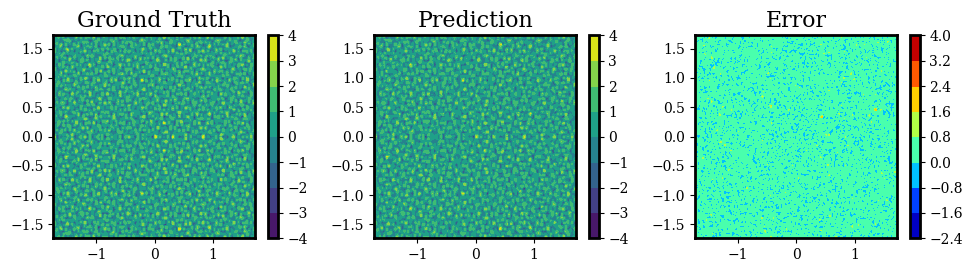

In [35]:
plt.figure(figsize = (10,3))
plt.subplot(1,3,1)
c = plt.tricontourf(X_test[:,0], X_test[:,1], Y_test)
plt.colorbar(c)
plt.title('Ground Truth')
plt.tight_layout()

plt.subplot(1,3,2)
c = plt.tricontourf(X_test[:,0], X_test[:,1], fit_model.net_apply(scaled_opt_params, X_test).flatten())
plt.colorbar(c)
plt.title('Prediction')
plt.tight_layout()

plt.subplot(1,3,3)
c = plt.tricontourf(X_test[:,0], X_test[:,1], Y_test - fit_model.net_apply(scaled_opt_params, X_test).flatten(), cmap = 'jet')
plt.colorbar(c)
# plt.title(r'Test Rel. $L_2$ : ' + f'{fit_model.l2_error(scaled_opt_params, (X_test, Y_test)):.1e}')
plt.title('Error')

plt.tight_layout()

plt.savefig(path + f'2d_toy_scaled_{int(max_freq)}.pdf', dpi = 200)

plt.show()
plt.close()

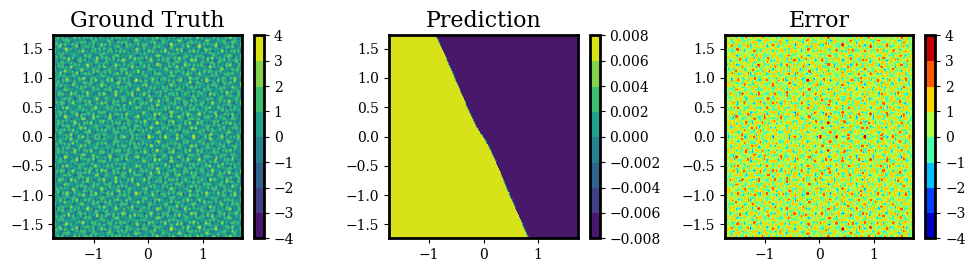

In [36]:
plt.figure(figsize = (10,3))
plt.subplot(1,3,1)
c = plt.tricontourf(X_test[:,0], X_test[:,1], Y_test)
plt.colorbar(c)
plt.title('Ground Truth')
plt.tight_layout()

plt.subplot(1,3,2)
c = plt.tricontourf(X_test[:,0], X_test[:,1], fit_model.net_apply(normal_opt_params, X_test).flatten())
plt.colorbar(c)
plt.title('Prediction')
plt.tight_layout()

plt.subplot(1,3,3)
c = plt.tricontourf(X_test[:,0], X_test[:,1], Y_test - fit_model.net_apply(normal_opt_params, X_test).flatten(), cmap = 'jet')
plt.colorbar(c)
# plt.title(r'Test Rel. $L_2$ : ' + f'{fit_model.l2_error(normal_opt_params, (X_test, Y_test)):.1e}')
plt.title('Error')


plt.tight_layout()

plt.savefig(path + f'2d_toy_normal_{int(max_freq)}.pdf', dpi = 200)

plt.show()
plt.close()

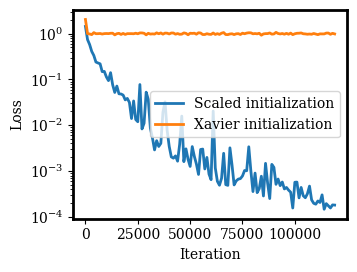

In [37]:
plt.figure(figsize = (4,3))
plt.plot(1000 * np.arange(loss_stor.shape[0]), loss_stor[:,1], label = 'Scaled initialization')
plt.plot(1000 * np.arange(loss_stor.shape[0]), loss_stor[:,0], label = 'Xavier initialization')
plt.yscale('log')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.tight_layout()
plt.savefig(path + f'2d_toy_loss_{int(max_freq)}.pdf', dpi = 200)
plt.show()
plt.close()

In [38]:
print(fit_model.l2_error(normal_opt_params, (X, Y)))
print(fit_model.l2_error(scaled_opt_params, (X, Y)))

0.99996775
0.011883356
